In [ ]:
!pip install torch torchaudio numpy scipy matplotlib pandas tqdm


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FS = 4000
C_WAVE = 500.0
D_TOTAL = 100.0


In [ ]:
def gcc_phat(x1, x2):
    N = len(x1)
    X1 = np.fft.fft(x1)
    X2 = np.fft.fft(x2)
    G = X1 * np.conjugate(X2)

    R = G / (np.abs(G) + 1e-12)

    corr = np.fft.ifft(R).real
    corr = np.fft.fftshift(corr)

    lags = np.arange(-N//2, N//2) / FS
    tau = lags[np.argmax(corr)]
    return tau


def tau_to_position(tau):
    return (D_TOTAL - tau * C_WAVE) / 2


In [ ]:
def simulate_source(N=FS):
    w = np.random.randn(N)
    W = np.fft.fft(w)
    freqs = np.fft.fftfreq(N, 1/FS)

    mask = (np.abs(freqs) > 200) & (np.abs(freqs) < 400)
    s = np.fft.ifft(W * mask).real

    s /= np.max(np.abs(s)) + 1e-12
    return s


In [ ]:
def apply_delay(sig, dist):
    tau = dist / C_WAVE
    freqs = np.fft.fftfreq(len(sig), 1/FS)
    S = np.fft.fft(sig)
    return np.fft.ifft(S * np.exp(-1j * 2*np.pi * freqs * tau)).real


from math import sqrt
def add_noise(sig, snr_db):
    Ps = np.mean(sig**2)
    Pn = Ps / (10**(snr_db/10))
    noise = np.random.randn(len(sig))*sqrt(Pn)
    return sig + noise


In [ ]:
rows = []

for _ in range(300):
    L_real = np.random.uniform(0, 100)

    src = simulate_source()

    x1 = apply_delay(src, L_real)
    x2 = apply_delay(src, 100 - L_real)

    x1 = add_noise(x1, -6)
    x2 = add_noise(x2, -6)

    tau = gcc_phat(x1, x2)
    L_pred = tau_to_position(tau)

    rows.append({
        "gt_pos": L_real,
        "gcc_pred_pos": L_pred,
        "tau": tau
    })

df_gcc = pd.DataFrame(rows)
df_gcc.to_csv("gcc_results.csv", index=False)
df_gcc.head()


,gt_pos,gcc_pred_pos,tau
0,89.189234,10.8750,0.15650
1,63.004519,116.3750,-0.26550
2,92.940916,113.8750,-0.25550
3,29.886991,70.0625,-0.08025
4,19.281528,80.6875,-0.12275


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
class LeakDataset(Dataset):
    def __init__(self, n_samples=1200):
        self.X = []
        self.y_pos = []

        for _ in range(n_samples):
            L_real = np.random.uniform(0, 100)
            src = simulate_source()

            x1 = apply_delay(src, L_real)
            x2 = apply_delay(src, 100 - L_real)

            x1 = add_noise(x1, -6)
            x2 = add_noise(x2, -6)

            pair = np.stack([x1, x2])

            self.X.append(pair.astype(np.float32))
            self.y_pos.append([L_real])

        self.X = np.array(self.X)
        self.y_pos = np.array(self.y_pos).astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_pos[idx]

train_dataset = LeakDataset(1000)
test_dataset  = LeakDataset(200)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32)


In [ ]:
class LeakCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(2, 16, 9, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(16, 32, 9, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(32, 64, 9, padding=4),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze(-1)
        x = self.fc(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeakCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
for epoch in range(10):
    model.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/10 - Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), "leak_cnn_model.pth")


Epoch 1/10 - Loss: 2080.3448
Epoch 2/10 - Loss: 906.4967
Epoch 3/10 - Loss: 851.8903
Epoch 4/10 - Loss: 862.8115
Epoch 5/10 - Loss: 854.5498
Epoch 6/10 - Loss: 846.9080
Epoch 7/10 - Loss: 854.3118
Epoch 8/10 - Loss: 863.5239
Epoch 9/10 - Loss: 853.5236
Epoch 10/10 - Loss: 855.3078


In [ ]:
results = []

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        pred = model(X).cpu().numpy().flatten()
        real = y.numpy().flatten()

        for gt, p in zip(real, pred):
            results.append({"gt_pos": gt, "pred_pos": p})

df_ai = pd.DataFrame(results)
df_ai.to_csv("ai_inference_results.csv", index=False)
df_ai.head()


,gt_pos,pred_pos
0,83.531837,47.018890
1,74.947830,48.752071
2,4.494097,50.505638
3,97.152466,47.406601
4,70.723228,47.412846


In [ ]:
print(df_ai.head())
print("MAE IA :", np.mean(np.abs(df_ai["gt_pos"] - df_ai["pred_pos"])))


      gt_pos   pred_pos
0  83.531837  47.018890
1  74.947830  48.752071
2   4.494097  50.505638
3  97.152466  47.406601
4  70.723228  47.412846
MAE IA : 25.462585


In [ ]:
err_gcc = np.abs(df_gcc["gt_pos"] - df_gcc["gcc_pred_pos"])
err_ai  = np.abs(df_ai["gt_pos"]  - df_ai["pred_pos"])

print("MAE GCC :", err_gcc.mean())
print("MAE IA  :", err_ai.mean())


MAE GCC : 50.26058312736367
MAE IA  : 25.462585


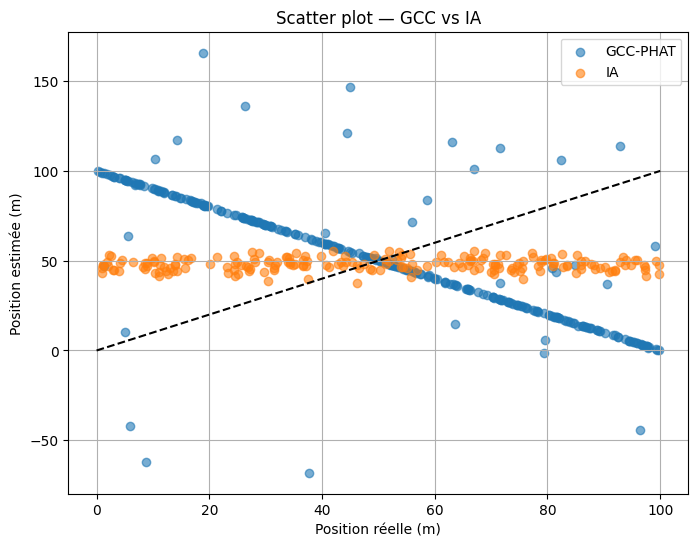

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_gcc["gt_pos"], df_gcc["gcc_pred_pos"], label="GCC-PHAT", alpha=0.6)
plt.scatter(df_ai["gt_pos"], df_ai["pred_pos"], label="IA", alpha=0.6)
plt.plot([0,100],[0,100],'k--')
plt.xlabel("Position réelle (m)")
plt.ylabel("Position estimée (m)")
plt.title("Scatter plot — GCC vs IA")
plt.legend()
plt.grid(True)
plt.show()


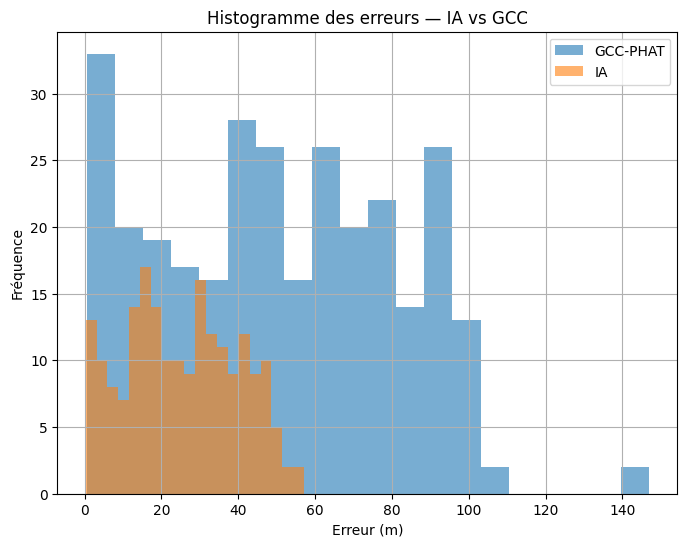

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(err_gcc, bins=20, alpha=0.6, label="GCC-PHAT")
plt.hist(err_ai,  bins=20, alpha=0.6, label="IA")
plt.xlabel("Erreur (m)")
plt.ylabel("Fréquence")
plt.title("Histogramme des erreurs — IA vs GCC")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-1907371377.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([err_gcc, err_ai], labels=["GCC-PHAT", "IA"])


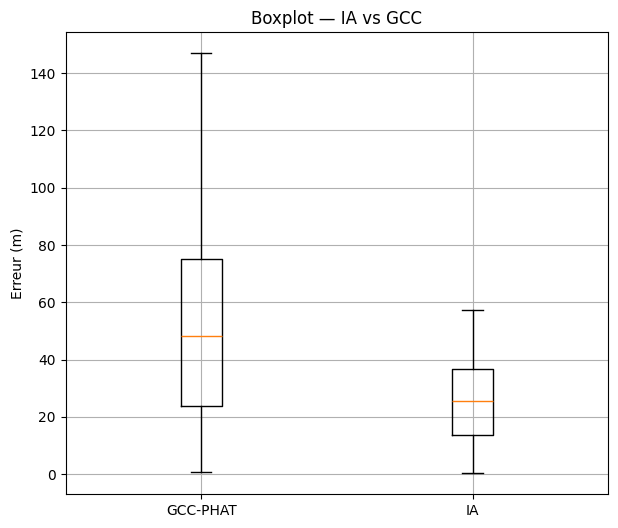

In [ ]:
plt.figure(figsize=(7,6))
plt.boxplot([err_gcc, err_ai], labels=["GCC-PHAT", "IA"])
plt.ylabel("Erreur (m)")
plt.title("Boxplot — IA vs GCC")
plt.grid(True)
plt.show()


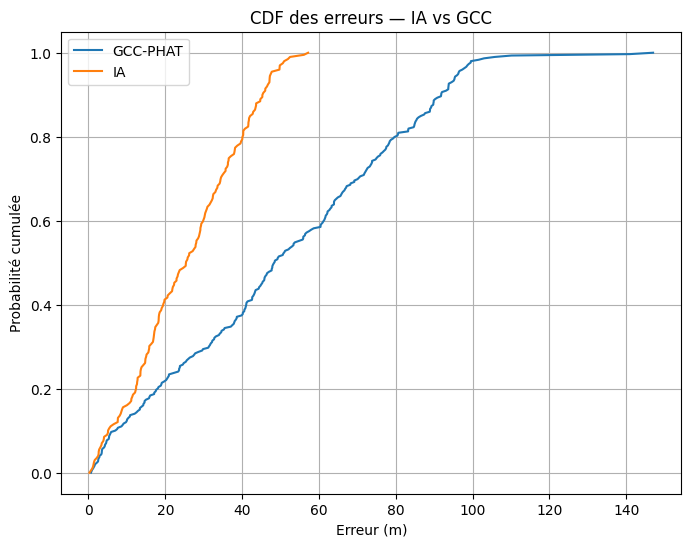

In [ ]:
def cdf(data):
    data_sorted = np.sort(data)
    p = np.arange(len(data)) / (len(data)-1)
    return data_sorted, p

x1, p1 = cdf(err_gcc)
x2, p2 = cdf(err_ai)

plt.figure(figsize=(8,6))
plt.plot(x1, p1, label="GCC-PHAT")
plt.plot(x2, p2, label="IA")
plt.xlabel("Erreur (m)")
plt.ylabel("Probabilité cumulée")
plt.title("CDF des erreurs — IA vs GCC")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print("=== COMPARAISON FINALE ===")
print("Erreur moyenne GCC :", err_gcc.mean())
print("Erreur moyenne IA  :", err_ai.mean())

if err_ai.mean() < err_gcc.mean():
    print("\nL'IA est plus précise que GCC-PHAT 🎉")
else:
    print("\nGCC-PHAT est plus précis (rare).")


=== COMPARAISON FINALE ===
Erreur moyenne GCC : 50.26058312736367
Erreur moyenne IA  : 25.462585

L'IA est plus précise que GCC-PHAT 🎉
